In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import os
from sklearn.metrics import mean_squared_error

method = 'ssvaer'
remain=0.2
batch_size = 200
if method == 'ssvaer':
    import models.ssvaer as myModel
elif method == 'svaer':
    import models.svaer as myModel
elif method == 'ssae':
    import models.ssae as myModel
elif method == 'fcn':
    import models.fcn as myModel
else:
    raise NotImplementedError

In [2]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(0)

In [3]:
import scipy.io as sio
def saveMat(train_x, train_y, train_unlabel, test_x, test_y, name_str):
    Xtrn_label = train_x[np.argwhere(train_unlabel==0)[:,0]]
    Xtrn_unlabel = train_x[np.argwhere(train_unlabel==1)[:,0]]
    Ytrn_label = train_y[np.argwhere(train_unlabel==0)[:,0]]
    Ytrn_unlabel = train_y[np.argwhere(train_unlabel==1)[:,0]]
    Xtst = test_x
    Ytst = test_y
    data_dict = {
        'Xtrn_label': Xtrn_label,
        'Xtrn_unlabel': Xtrn_unlabel,
        'Ytrn_label': Ytrn_label,
        'Ytrn_unlabel': Ytrn_unlabel,
        'Xtst': Xtst,
        'Ytst': Ytst
    }
    sio.savemat(name_str+'.mat', data_dict)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#device="cpu"

def genUnlabelList(data, label, remain = 0.2, mode = '2D'):
    if mode == '2D':
        label_idx = np.arange(0, data.shape[0], int(1/remain), dtype=int)
        unlabel_idx = np.ones((data.shape[0],1)).astype('int')
    elif mode == '3D':
        label_idx = np.arange(0, data.shape[1], int(1/remain), dtype=int)
        unlabel_idx = np.ones((data.shape[1],1)).astype('int')
    unlabel_idx[label_idx]=0
    return unlabel_idx

def strip_data(arr,unlabel_idx):
   return arr[np.argwhere(unlabel_idx==0)[:,0]]

data = pd.read_csv('data/Debutanizer_Column_Data.txt', sep='\s+')
data = data.values

x_temp = data[:, :7]
y_temp = data[:, 7]

TRAIN_SIZE = 1200
VAL_SIZE = 400

x_new = np.zeros([2390, 10])
x_6 = x_temp[:, 4]
x_9 = (x_temp[:, 5] + x_temp[:, 6])/2
x_new[:, :5] = x_temp[4: 2394, :5]

x_new[:, 5] = x_6[3: 2393]
x_new[:, 6] = x_6[2: 2392]
x_new[:, 7] = x_6[1: 2391]
x_new[:, 8] = x_9[4: 2394]
x_new[:, 9] = y_temp[:2390]
#x_new[:, 9] = y_temp[3: 2393]
#x_new[:, 10] = y_temp[2: 2392]
#x_new[:, 11] = y_temp[1:2391]
#x_new[:, 12] = y_temp[:2390]
y_new = y_temp[4: 2394]
y_new = y_new.reshape([-1, 1])

train_x = x_new[:TRAIN_SIZE, :]
train_y = y_new[:TRAIN_SIZE]

val_x = x_new[TRAIN_SIZE:TRAIN_SIZE+VAL_SIZE, :]
val_y = y_new[TRAIN_SIZE:TRAIN_SIZE+VAL_SIZE]

test_x = x_new[TRAIN_SIZE+VAL_SIZE:2390, :]
test_y = y_new[TRAIN_SIZE+VAL_SIZE:2390]

train_unlabel = genUnlabelList(train_x, train_y, remain = remain, mode='2D')
val_unlabel = genUnlabelList(val_x, val_y, remain = remain, mode='2D')
test_unlabel = genUnlabelList(test_x, test_y, remain = remain, mode='2D')

fake_train_y = train_y.copy()
fake_train_y[np.argwhere(train_unlabel)[:,0]] = 0
fake_val_y = val_y.copy()
fake_val_y[np.argwhere(val_unlabel)[:,0]] = 0
if method == 'ssvaer':
    train_dataset = myModel.MyDataset(torch.tensor(train_x[:-1], dtype=torch.float32, device=device),
                            torch.tensor(train_x[1:], dtype=torch.float32, device=device),
                            torch.tensor(fake_train_y[:-1], dtype=torch.float32, device=device),
                            torch.tensor(train_unlabel[:-1], dtype=torch.int, device=device))
    val_dataset = myModel.MyDataset(torch.tensor(val_x[:-1], dtype=torch.float32, device=device),
                            torch.tensor(val_x[1:], dtype=torch.float32, device=device),
                            torch.tensor(fake_val_y[:-1], dtype=torch.float32, device=device),
                            torch.tensor(val_unlabel[:-1], dtype=torch.int, device=device))
else:
    train_dataset = myModel.MyDataset(torch.tensor(train_x, dtype=torch.float32, device=device),
                            torch.tensor(fake_train_y, dtype=torch.float32, device=device),
                            torch.tensor(train_unlabel, dtype=torch.int, device=device))
    val_dataset = myModel.MyDataset(torch.tensor(val_x, dtype=torch.float32, device=device),
                            torch.tensor(fake_val_y, dtype=torch.float32, device=device),
                            torch.tensor(val_unlabel, dtype=torch.int, device=device))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
dataloader_dict ={'train' : train_dataloader, 'val' : val_dataloader}
print('Num of unlabelled in Train: {}, labelled: {}'.format(np.sum(train_unlabel), train_unlabel.shape[0]-np.sum(train_unlabel)))

Num of unlabelled in Train: 960, labelled: 240


In [5]:
# share_dim: list, encode_dim: list, regressor_dim: list, latentgen_dim:list

if method == 'ssvaer':
    custom_model = myModel.SSVAE([10,10,7],[7,4,4],[7,4,1],[2,2,4])
    custom_trainer = myModel.SSVAE_Trainer(dataloader_dict = dataloader_dict, model=custom_model, epoch=300, lr=0.01, scheduler=True, verbose=True, betaSchedule=None)
elif method == 'svaer':
    custom_model = myModel.SVAE([10,10,7],[7,4,4],[7,4,1],[1,4])
    custom_trainer = myModel.SVAE_Trainer(dataloader_dict = dataloader_dict, model=custom_model, epoch=300, lr=0.01, scheduler=True, verbose=True, betaSchedule=None)
elif method == 'ssae':
    custom_model = myModel.SSAE(AE_list=[10,10,7,4])
    custom_trainer = myModel.SSAE_Trainer(dataloader_dict = dataloader_dict, model=custom_model, pretrain_lr=0.01, pretrain_epoch=10, finetune_lr=0.01, finetune_epoch = 250, tradeoff_param=1, scheduler=True, verbose=True)
elif method == 'fcn':
    custom_model = myModel.FCN([10,10,7,4,1])
    custom_trainer = myModel.FCN_Trainer(dataloader_dict = dataloader_dict, model=custom_model, epoch=300, lr=0.01, scheduler=True, verbose=True)

Using CosineAnnealingWarmupRestarts lr.
Using cuda:0 device
PyTorch Version:  1.11.0


In [6]:
custom_trainer.train()

last lr:  [0.00026500000000000004]
Epoch 1/300, train total: 13.300963,reconstruct: 11.084160,kld: 1.261111,label: 0.955691, 
 val total: 10.694368,reconstruct: 8.914301,kld: 0.848092,label: 0.931974
last lr:  [0.0019150000000000003]
Epoch 11/300, train total: 4.514061,reconstruct: 3.036095,kld: 0.580818,label: 0.897147, 
 val total: 4.190671,reconstruct: 2.689735,kld: 0.549212,label: 0.951724
last lr:  [0.0035650000000000005]
Epoch 21/300, train total: 0.018941,reconstruct: 0.452557,kld: 0.019226,label: -0.452842, 
 val total: -0.226464,reconstruct: 0.365510,kld: 0.017122,label: -0.609096
last lr:  [0.005215]
Epoch 31/300, train total: -3.473367,reconstruct: 0.072355,kld: 0.006294,label: -3.552016, 
 val total: -1.962031,reconstruct: 0.093238,kld: 0.007902,label: -2.063172
last lr:  [0.006865000000000001]
Epoch 41/300, train total: -4.954060,reconstruct: 0.037255,kld: 0.011737,label: -5.003053, 
 val total: -4.076736,reconstruct: 0.076366,kld: 0.022390,label: -4.175492
last lr:  [0.00

-4.956973552703857

Validation,  ssvaer 0.2
MSE:  0.002225247151579149
RMSE:  0.04717252538903497


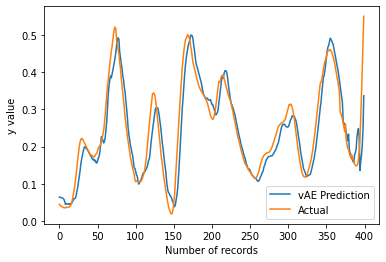

In [7]:
with torch.no_grad():
    if method == 'ssae':
        _,outputs = custom_model(torch.tensor(val_x, dtype=torch.float32, device=device),0)
    else:
        outputs = custom_model(torch.tensor(val_x, dtype=torch.float32, device=device))
pred = outputs
#pred = outputs
plt.plot(pred.cpu().detach().numpy(), label='vAE Prediction')
plt.plot(val_y, label='Actual')
plt.xlabel('Number of records')
plt.ylabel('y value')
plt.legend()
print('Validation, ',method, remain)
print('MSE: ', mean_squared_error(val_y, pred.cpu().detach().numpy()))
print('RMSE: ', np.sqrt(mean_squared_error(val_y, pred.cpu().detach().numpy())))

Test,  ssvaer 0.2
MSE:  0.002207571097692118
RMSE:  0.04698479645259856


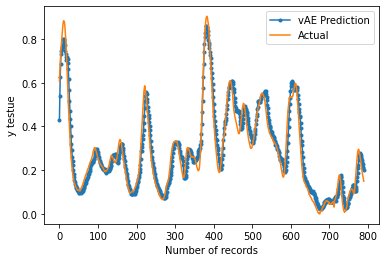

In [8]:
with torch.no_grad():
    if method == 'ssae':
        _,outputs = custom_model(torch.tensor(test_x, dtype=torch.float32, device=device),0)
    else:
        outputs = custom_model(torch.tensor(test_x, dtype=torch.float32, device=device))
pred = outputs
plt.plot(pred.cpu().detach().numpy(), label='vAE Prediction', marker='o', markersize=3)
plt.plot(test_y, label='Actual')
plt.xlabel('Number of records')
plt.ylabel('y testue')
plt.legend()
print('Test, ',method, remain)
print('MSE: ', mean_squared_error(test_y, pred.cpu().detach().numpy()))
print('RMSE: ', np.sqrt(mean_squared_error(test_y, pred.cpu().detach().numpy())))
#np.save('pred/'+'debut_'+method+str(int(100*remain))+'.npy', pred.cpu().detach().numpy())

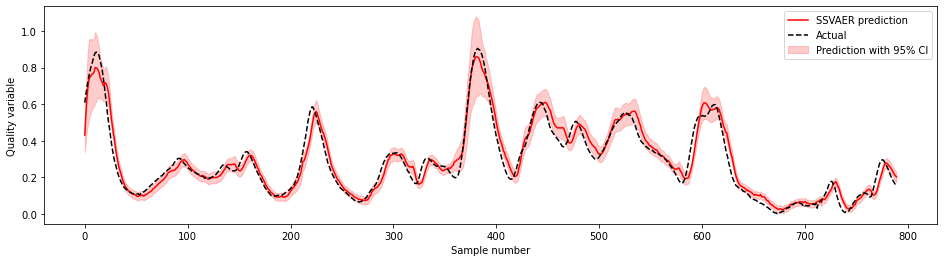

In [9]:
if 'svae' in method:
    with torch.no_grad():
        y_logvar = custom_model.y_logvar_regressor(custom_model.share_encoder(torch.tensor(test_x, dtype=torch.float32, device=device)))
        outputs = custom_model(torch.tensor(test_x, dtype=torch.float32, device=device))
    pred = outputs
    pred = pred.cpu().detach().numpy().ravel()
    y_logvar = y_logvar.cpu().detach().numpy()
    ci = 1/np.exp(-y_logvar/2)
    ci = ci.ravel()
    plt.figure(figsize=(16, 4))
    plt.plot(pred, color='red',label='SSVAER prediction')
    plt.plot(test_y, '--',color='black',label='Actual')
    plt.fill_between(np.arange(pred.shape[0]).ravel(), pred-ci, pred+ci, color='red', alpha=.2, label='Prediction with 95% CI')
    plt.xlabel('Sample number')
    plt.ylabel('Quality variable')
    plt.legend()
    #plt.savefig('figs/debut_ci.png')

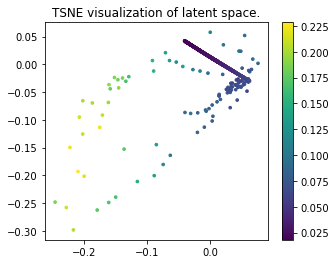

In [10]:
if 'svae' in method:
    from sklearn.manifold import MDS
    mu = custom_model.mean_encoder(custom_model.share_encoder(torch.tensor(test_x, dtype=torch.float32, device=device)))
    #test_trend = custom_model.trend_regressor(custom_model.share_encoder(torch.tensor(test_x, dtype=torch.float32, device=device))).cpu().detach().numpy()
    y_logvar = custom_model.y_logvar_regressor(custom_model.share_encoder(torch.tensor(test_x, dtype=torch.float32, device=device))).cpu().detach().numpy()
    y_logvar = np.sqrt(np.exp(y_logvar))
    tsne = MDS(n_components=2, random_state=0)
    X_2d = tsne.fit_transform(mu.cpu().detach().numpy())
    #%matplotlib notebook
    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(111)
    sc=ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y_logvar,s=7)
    plt.title('TSNE visualization of latent space.')
    plt.colorbar(sc)
    #plt.savefig('debut_tsne.png')
